In [1]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import japanize_matplotlib
from IPython.display import display

# torch関連ライブラリのインポート
import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
from torch.autograd import Variable

In [2]:
# デバイスの割り当て
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [3]:
df = pd.read_csv('n1c1o.csv')
df2 = pd.read_csv('n1c1p.csv')
df3 = pd.read_csv('n1c3o.csv')
df4 = pd.read_csv('n3c1o.csv')

In [4]:
phi = np.array( df.columns).astype(float)
phi2 = np.array( df2.columns).astype(float)
phi3 = np.array( df3.columns).astype(float)
phi4 = np.array( df4.columns).astype(float)

In [5]:
x = np.array(df).astype(complex)
x2 = np.array(df2).astype(complex)
x3 = np.array(df3).astype(complex)
x4 = np.array(df4).astype(complex)

In [6]:
#absでいい？absにしなくてもerrorはでない　実部と虚部にわける？
x = np.abs( x )
x2 = np.abs(x2)
x3 = np.abs(x3)
x4 = np.abs(x4)

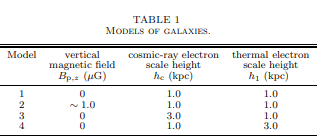

In [248]:
#ひとつにまとめる
x_data = np.vstack([x, x2, x3, x4])
y_data = np.vstack([np.tile( np.array( [ 0, 1.0, 1.0 ] ), (800,1)),
                    np.tile( np.array( [ 1.0, 1.0, 1.0 ] ), (800,1)),
                    np.tile( np.array( [ 0, 3.0, 1.0 ] ), (800, 1)),
                    np.tile( np.array( [ 0, 1.0, 3.0 ] ), (800, 1))
                   ])

In [8]:
# train setと検証 set に分割
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, random_state=123)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(2400, 20000) (800, 20000) (2400, 3) (800, 3)


In [9]:
# データローダーの定義

# ミニバッチのサイズ指定
batch_size = 100

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_data = TensorDataset(torch.from_numpy(x_train).float(), torch.from_numpy(y_train).float())
train_loader1 = DataLoader(train_data, batch_size = batch_size, shuffle=True)

# 検証用データローダー
# 検証時にシャッフルは不要
test_data = TensorDataset(torch.from_numpy(x_test).float(), torch.from_numpy(y_test).float())
test_loader1 = DataLoader(train_data, batch_size, shuffle=True)

In [10]:
# train_loader1から1セット取得
for images1, labels1 in train_loader1:
    break
labels1 = labels1.float()
# それぞれのshape確認
print(images1.shape)
print(labels1.shape)

torch.Size([100, 20000])
torch.Size([100, 3])


In [11]:
# モデルの引数と入力が同じ型でないとエラーが出るためいたるところにfloat()とlong()があるがこんなになくてもいい
# 損失計算用
def eval_loss(loader, device, net):
  
    # データローダーから最初の1セットを取得する
    for images, labels in loader:
        break

    # デバイスの割り当て
    inputs = images.to(device).float()
    labels = labels.to(device).float()

    # 予測計算
    outputs = net(inputs.float())

    #  損失計算
    loss = RMS(outputs.float(), labels.float())

    return loss

In [275]:
# 学習用関数
def fit(net, optimizer, num_epochs, train_loader, test_loader, device, history):

    # tqdmライブラリのインポート
    from tqdm.notebook import tqdm

    base_epochs = len(history)
  
    for epoch in range(base_epochs, num_epochs+base_epochs):
        train_loss = 0
        test_loss = 0

        #訓練フェーズ
        net.train()
        count = 0

        for inputs, labels in tqdm(train_loader):
            count += len(labels)
            inputs = inputs.to(device).float()
            labels = labels.to(device).float()
            
            # 勾配の初期化
            optimizer.zero_grad()
            
            
            # 予測計算
            outputs = net(inputs.float()).float()
            
            #値の制限 下限を０
            outputs = torch.clamp(input=outputs, min= 0)
            
            # 損失計算 ここではRMSで計算
            loss = RMS( outputs, labels )
            train_loss += loss

            # 勾配計算
            loss.backward()

            # パラメータ修正
            optimizer.step()

        #予測フェーズ
        net.eval()
        count = 0

        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 予測計算
            outputs = net(inputs)
            
            #値の制限 下限を０
            #outputs = torch.clamp(input=outputs, min= 0)
            
            # 損失計算
            loss = RMS(outputs, labels.float())
            test_loss += loss
            
        print( f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], train loss: {train_loss:.3f}, val_loss: {test_loss:.3f}')
        train_loss = train_loss.detach().numpy()
        test_loss = test_loss.detach().numpy()
        item = np.array([epoch+1, train_loss, test_loss])
        
        history = np.vstack((history, item))
    return history

In [276]:
# 学習ログ解析
def evaluate_history(history):

    num_epochs = len(history)
    unit = num_epochs / 10

    # 学習曲線の表示 (損失)
    plt.figure()
    plt.plot(history[:,0], history[:,1], c = 'r', label='train')
    plt.plot(history[:,0], history[:,2], 'c', label='test')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('number epoch')
    plt.ylabel('loss')
    plt.title('Learning Curve(loss)')
    plt.legend()
    plt.show()

In [277]:
# PyTorch乱数固定用
def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

In [278]:
# train_loader1から1セット取得
for images1, labels1 in train_loader1:
    break
labels1 = labels1.float()
# それぞれのshape確認
print(images1.shape)
print(labels1.shape)

torch.Size([100, 20000])
torch.Size([100, 3])


In [279]:
#n_input = image1.view(-1).shape[0]
n_input = images1[0].shape
# 出力次元数
n_output = labels1.shape[1]

# 結果確認
print(f'n_input: {n_input}, n_output: {n_output}')

n_input: torch.Size([20000]), n_output: 3


In [280]:
class NN(nn.Module):
  def __init__(self, n_output):
    super().__init__()
    self.maxpool = nn.MaxPool1d(5)
    self.relu = nn.ReLU(inplace=True)
    self.l1 = nn.Linear(20000, 512)
    self.l2 = nn.Linear(512, 3)
    
    self.features = nn.Sequential(
        
        self.maxpool)
    
    self.classifier = nn.Sequential(
        self.l1,
        self.relu,
        self.l2,
    )

  def forward(self, x):
    x = self.classifier(x)
    return x

In [281]:
def RMS(y, y_p):
    return ((y_p - y)**2).mean()

In [282]:
# モデルインスタンス生成
net = NN(n_output).to(device)

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [283]:
# モデルの概要表示
print(net)

NN(
  (maxpool): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU(inplace=True)
  (l1): Linear(in_features=20000, out_features=512, bias=True)
  (l2): Linear(in_features=512, out_features=3, bias=True)
  (features): Sequential(
    (0): MaxPool1d(kernel_size=5, stride=5, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=20000, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=3, bias=True)
  )
)


In [284]:
# 損失計算
loss = eval_loss(test_loader1, device, net)

In [ ]:
%%time
# 乱数初期化
torch_seed()

# モデルインスタンス生成
net = NN(n_output).to(device)

# 損失関数： 平均二乗誤差
criterion = nn.MSELoss

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 500

# 評価結果記録用
history = np.zeros((0,3))

# 学習
history = fit(net, optimizer, num_epochs, train_loader1, test_loader1, device, history)

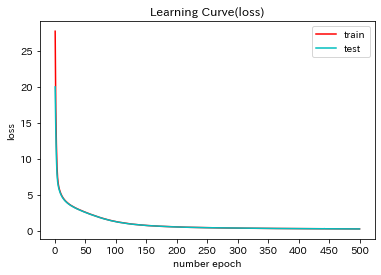

In [297]:
# 評価
evaluate_history(history)

In [315]:
# Evaluate the model
test_var = Variable(torch.FloatTensor(x), requires_grad=True)
with torch.no_grad():
    result = net(test_var)
result = torch.clip(result, min = 0)
result = result.detach().numpy()

In [334]:
from uncertainties import ufloat
from uncertainties.umath import * 
from uncertainties import unumpy as unp

In [369]:
# Evaluate the model
test_var = Variable(torch.FloatTensor(x), requires_grad=True)
with torch.no_grad():
    result = net(test_var)
result = torch.clip(result, min = 0)
result = result.detach().numpy()
t00 = ufloat( np.mean( result[:,0] ), np.std(result[:,0]))
t01 = ufloat( np.mean( result[:,1] ), np.std(result[:,1]))
t02 = ufloat( np.mean( result[:,2] ), np.std(result[:,2]))

In [370]:
# Evaluate the model
test_var = Variable(torch.FloatTensor(x2), requires_grad=True)
with torch.no_grad():
    result = net(test_var)
result = torch.clip(result, min = 0)
result = result.detach().numpy()
t10 = ufloat( np.mean( result[:,0] ), np.std(result[:,0]))
t11 = ufloat( np.mean( result[:,1] ), np.std(result[:,1]))
t12 = ufloat( np.mean( result[:,2] ), np.std(result[:,2]))

In [371]:
# Evaluate the model
test_var = Variable(torch.FloatTensor(x3), requires_grad=True)
with torch.no_grad():
    result = net(test_var)
result = torch.clip(result, min = 0)
result = result.detach().numpy()
t20 = ufloat( np.mean( result[:,0] ), np.std(result[:,0]))
t21 = ufloat( np.mean( result[:,1] ), np.std(result[:,1]))
t22 = ufloat( np.mean( result[:,2] ), np.std(result[:,2]))

In [372]:
# Evaluate the model
test_var = Variable(torch.FloatTensor(x4), requires_grad=True)
with torch.no_grad():
    result = net(test_var)
result = torch.clip(result, min = 0)
result = result.detach().numpy()
t30 = ufloat( np.mean( result[:,0] ), np.std(result[:,0]))
t31 = ufloat( np.mean( result[:,1] ), np.std(result[:,1]))
t32 = ufloat( np.mean( result[:,2] ), np.std(result[:,2]))

In [375]:
df = pd.DataFrame({'B': [t00, t10, t20, t30],
                   'hc': [t01, t11, t21, t31],
                   'h1': [t02, t12, t22, t32]
                  },
                  index=['model1', 'model2', 'model3', 'model4'])

In [376]:
df

,B,hc,h1
model1,0.014+/-0.035,1.04+/-0.10,1.01+/-0.09
model2,0.98+/-0.07,0.999+/-0.013,1.04+/-0.11
model3,0.006+/-0.009,2.97+/-0.27,1.005+/-0.020
model4,0.04+/-0.06,1.001+/-0.016,2.96+/-0.20


In [342]:
table4 = pd.DataFrame(
 index = ['model1', 'model2', 'model3', 'model4']
)

In [343]:
table4

""
model1
model2
model3
model4
